In [5]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error

from airpollution_trf_graph_loader import AirpollutionDatasetLoader

pd.options.display.float_format = '{:,.3f}'.format

### Auxiliary functions

In [6]:
def mape_fn(actual, pred):
    #print(actual)
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+0.01))) * 100

def compute_metrics_as_dataframe_fn(y_valid, y_hat, particle_name):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    try:
        mae = mean_absolute_error(y_valid, y_hat)
        mse = mean_squared_error(y_valid, y_hat)
        rmse= mean_squared_error(y_valid, y_hat, squared = False)
        cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
        mape = mape_fn(y_valid, y_hat)

        metrics.append((time_horizon, str(particle_name), mae, mse, rmse, cvrmse, mape))


        metrics_df = pd.DataFrame.from_records(metrics, columns='T particle MAE MSE RMSE CVRMSE MAPE'.split())

        return metrics_df
    except:
        return None

def compute_metrics(y_valid, y_hat):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    mae = mean_absolute_error(y_valid, y_hat)
    mse = mean_squared_error(y_valid, y_hat)
    rmse= mean_squared_error(y_valid, y_hat, squared = False)
    cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
    mape = mape_fn(y_valid, y_hat)

    return mae, mse, rmse, cvrmse, mape

In [7]:
T_lst= [6,12,24,48] #target time horizons to analyze
city_lst= 'madrid bilbao'.split()
_synth= False #use or not the results with synth data
n_layers= 1 #number of lstm layers in the used GNN

results_path='results'
if n_layers==2:
    results_dir= 'results_2lstmlayers'



************************
madrid
********
METRICS BY POLLUTANT
****
madrid - 12h time horizon
                        MAE     MSE   RMSE  CVRMSE    MAPE
pollutant T  traffic                                      
CO        12 no_trf   0.187   0.071  0.229  59.376  73.653
             trf      0.171   0.069  0.227  58.763  60.016
O3        12 no_trf  21.033 617.888 24.806  85.844 215.885
             trf     20.190 573.907 23.929  82.688 207.973
PM10      12 no_trf  11.639 345.247 17.861  58.366  29.364
             trf     11.998 356.882 18.165  59.366  30.451
PM25      12 no_trf   4.884  43.007  6.504  50.066  34.658
             trf      5.025  45.100  6.659  51.254  35.434
SO2       12 no_trf   0.570   0.428  0.594  43.554  50.796
             trf      0.554   0.462  0.580  41.010  48.176
****
madrid - 24h time horizon
                       MAE     MSE   RMSE  CVRMSE   MAPE
pollutant T  traffic                                    
CO        24 no_trf  0.112   0.021  0.134  34.436 47

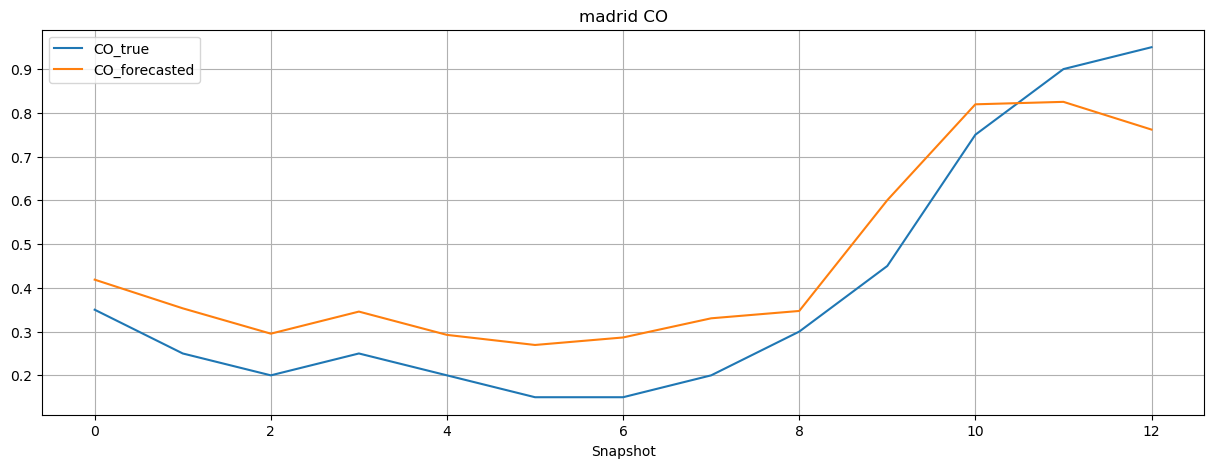

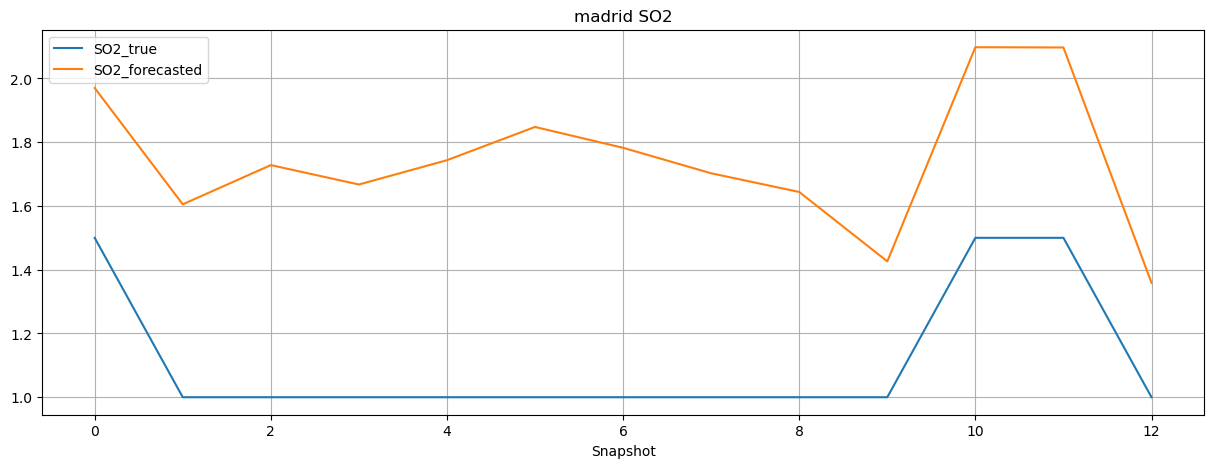

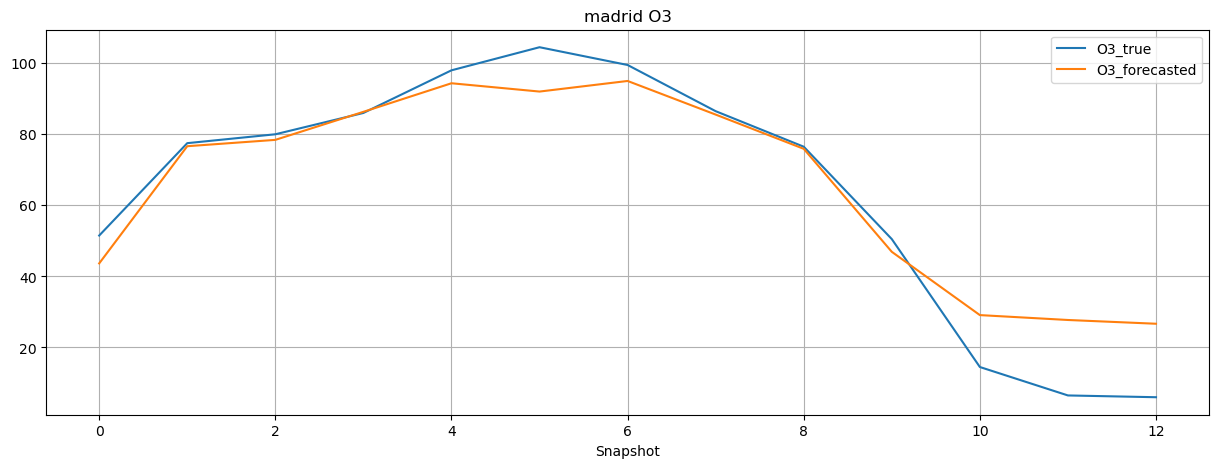

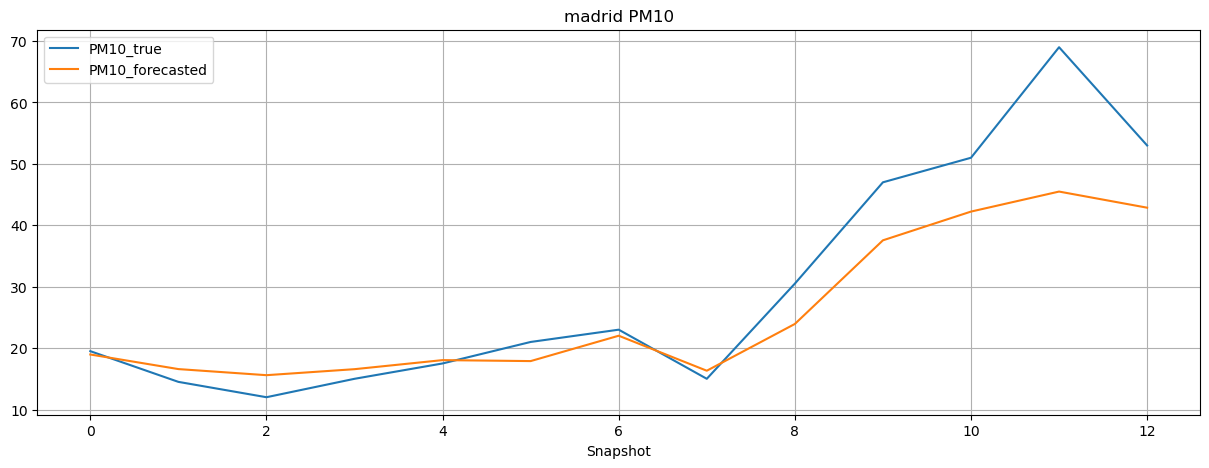

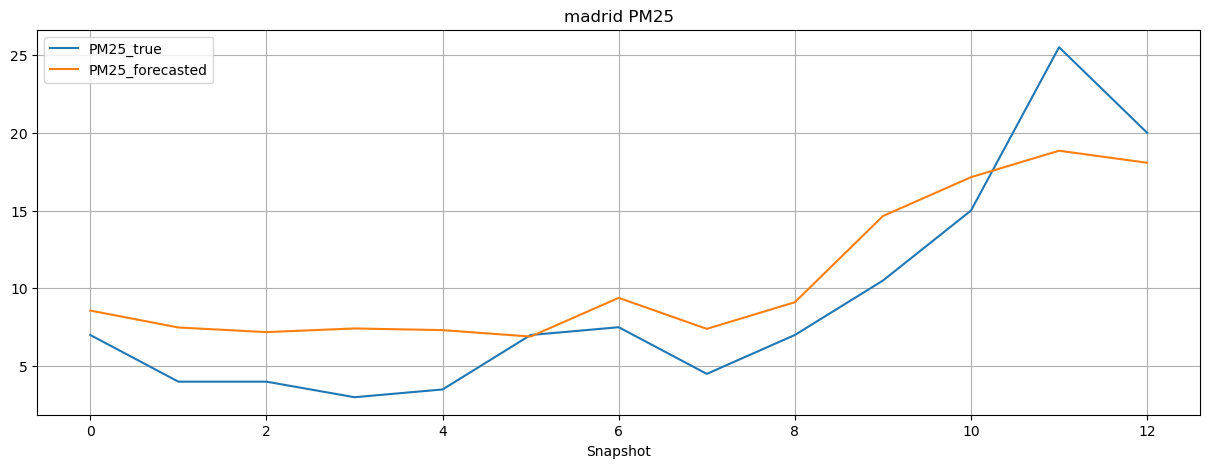

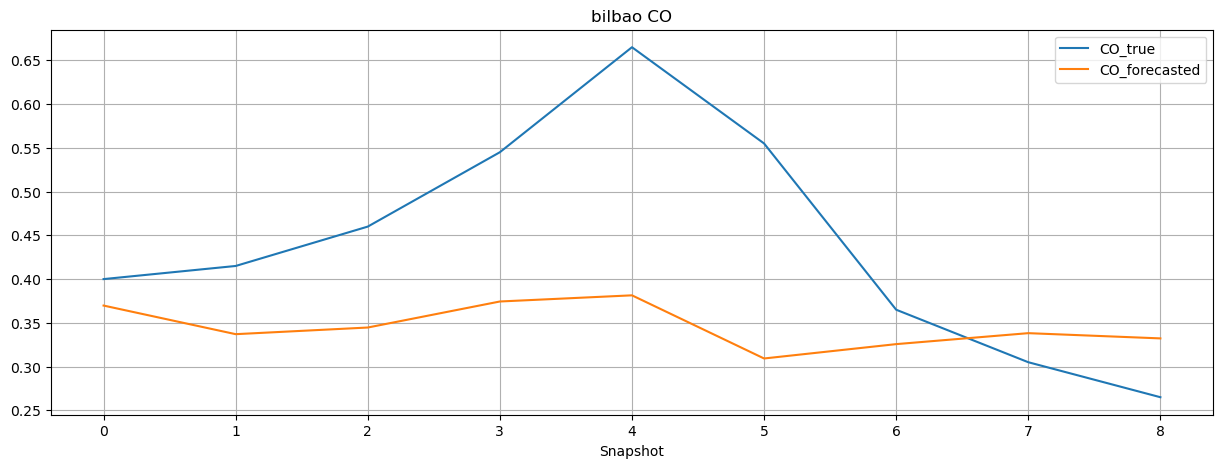

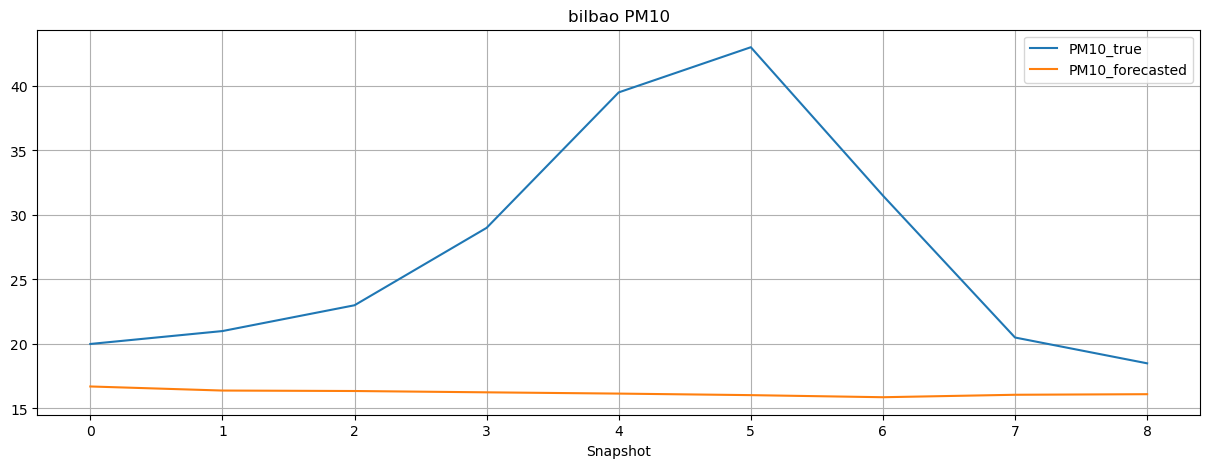

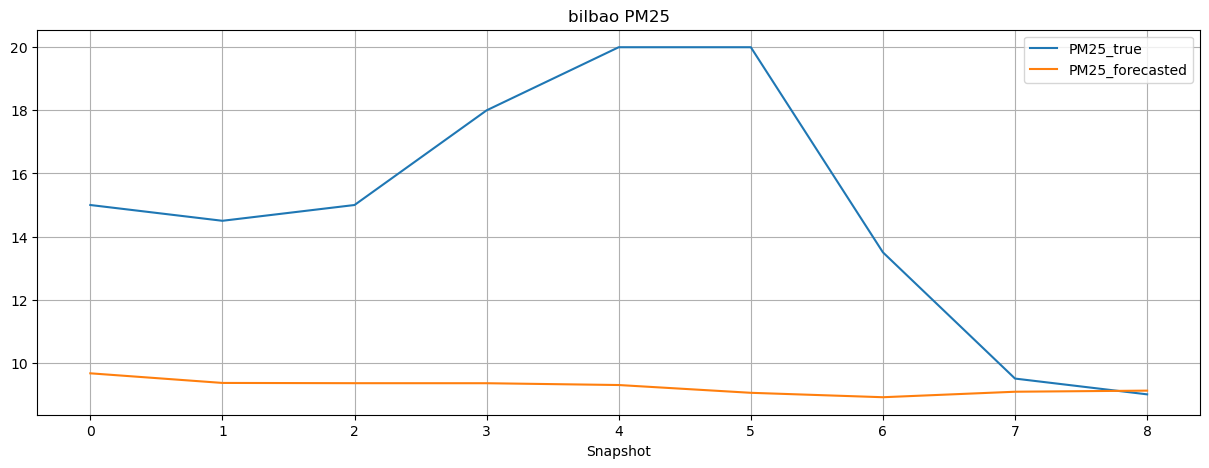

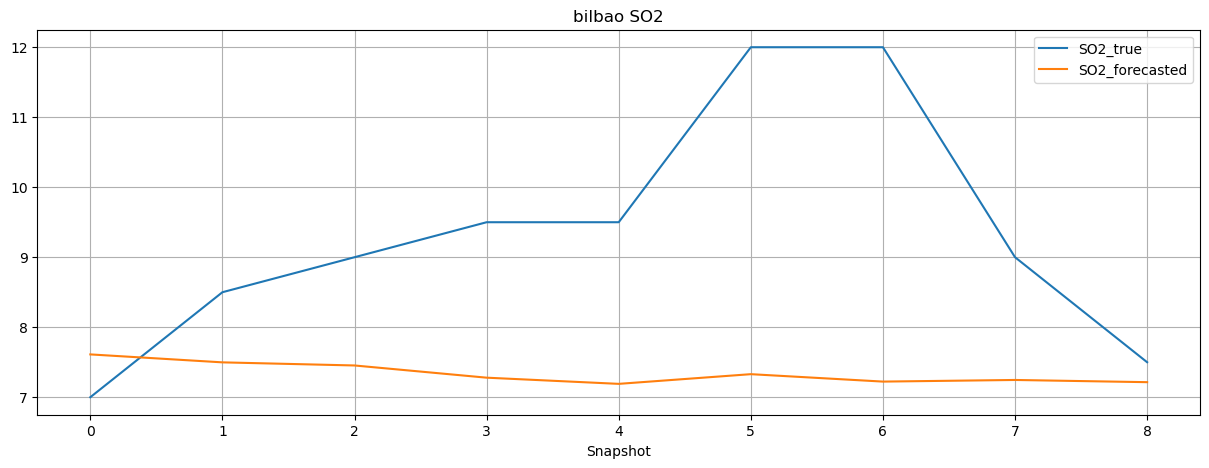

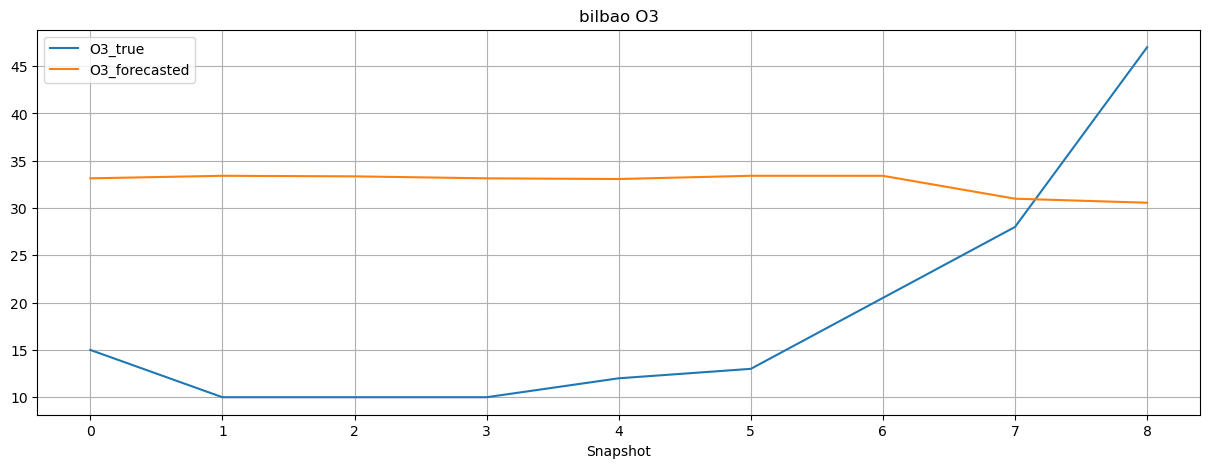

In [30]:
synth_data_str=""
if _synth:
    synth_data_str="_synth"

n_layers_str=""
if n_layers > 1 :
    n_layers_str= f'_{n_layers}'

for _city in city_lst:
    print("\n")
    print("*"*24)

    print(f"{_city}{synth_data_str}")
    loader= AirpollutionDatasetLoader(_city)
    dataset=loader.get_dataset(T=T_lst[0])

    feature_dim= loader.get_feature_dim()
    target_nodes= list(feature_dim.keys())

    y_hat_dict= {}
    y_true_dict= {}
    
    for _trf_str in ['trf', 'no_trf']:    
        for _T in T_lst:
            for k in target_nodes:
                if (_trf_str !=  'no_trf') or (k != 'trf'):
                    _df= pd.read_csv(os.path.join(results_path,f'y_hat_{_city}_{_T}_{k}_{_trf_str}{synth_data_str}.csv'), index_col=0)
                    y_hat_dict['_'.join([str(_T),k,_trf_str])]= _df
                
                    _df= pd.read_csv(os.path.join(results_path,f'y_true_{_city}_{_T}_{k}_{_trf_str}{synth_data_str}.csv'), index_col=0)
                    y_true_dict['_'.join([str(_T),k,_trf_str])]= _df


    metrics_by_sensors= []
    metrics_by_pollutants= []
    for _trf_str in ['trf', 'no_trf']:    
        for _T in T_lst:
            for k in target_nodes:
                if k != 'trf':
                    y_true_df= y_true_dict['_'.join([str(_T),k,_trf_str])]
                    y_hat_df= y_hat_dict['_'.join([str(_T),k,_trf_str])]
                
                    #Metris by station
                    for i in range(y_true_df.shape[0]):
                        mae, mse, rmse, cvrmse, mape= compute_metrics(y_true_df.iloc[i], y_hat_df.iloc[i])
                        #print(y_true_df, y_hat_df, mae, mse, rmse, cvrmse, mape)
                        metrics_by_sensors.append((_T, _trf_str, k, i, mae, mse, rmse, cvrmse, mape))
                
                    for c in y_true_df.columns:
                        c_hat= y_hat_df[c].T
                        c_true= y_true_df[c].T
                        mae, mse, rmse, cvrmse, mape= compute_metrics(c_true, c_hat)
                        metrics_by_pollutants.append((_T, _trf_str, k, c, mae, mse, rmse, cvrmse, mape))
    
    
    metrics_by_sensors_df = pd.DataFrame.from_records(metrics_by_sensors, columns='T traffic sensor t MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_by_pollutants_df = pd.DataFrame.from_records(metrics_by_pollutants, columns='T traffic sensor pollutant MAE MSE RMSE CVRMSE MAPE'.split())
    
    metrics_by_sensors_df.to_csv(os.path.join(results_path,f'metrics_by_sensor_{_city}{synth_data_str}.csv'))
    metrics_by_pollutants_df.to_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}{synth_data_str}.csv'))

    print("*"*8)
    print("METRICS BY POLLUTANT")
    for t in T_lst:
        print("*"*4)
        print(f"{_city} - {t}h time horizon")
        metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==t].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
        print(metric_agg_mean_df)

    print("*"*8)
    print("METRICS BY SENSORS")
    for t in T_lst:
        print(f"{_city} - {t}h time horizon")
        metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==t].groupby('sensor T traffic'.split()).mean()
        print(metric_agg_mean_df)  
        print("*"*4)  

    print("*"*8)
    print("FORECASTED VS REAL PLOTS")

    T_to_plot= '24'
    if _city== 'bilbao':
        T_to_plot= '12'
    y_true_lst={}
    y_hat_lst={}
    for k,df in y_true_dict.items():
        T_k= k.split('_')[0]
        trf_k= k.split('_')[2]
        s_k = k.split('_')[1]
        if (T_to_plot == T_k) and (trf_k== 'trf') and (s_k != 'trf'): # We plot pollution sensors including traffic as input
            y_hat_df= y_hat_dict[k]
            for c in df.columns:
                df_lst= y_true_lst.get(c,[])
                df_lst.append(df[c].to_frame().reset_index())
                y_true_lst[c]= df_lst
    
                df_lst= y_hat_lst.get(c,[])
                df_lst.append(y_hat_df[c].to_frame().reset_index())
                y_hat_lst[c]= df_lst
    
    for k, lst in y_true_lst.items():
        
        df= pd.concat(lst, axis=0)
        df= df.groupby('index').mean()
        df= df.rename(columns={k:f'{k}_true'})
    
        lst2= y_hat_lst[k]
        y_hat_df= pd.concat(lst2, axis=0)
        y_hat_df= y_hat_df.groupby('index').mean()
        y_hat_df= y_hat_df.rename(columns={k:f'{k}_forecasted'})
        
        ax=df.plot(grid=True, figsize=(15,5));
        y_hat_df.plot(ax=ax, grid=True, xlabel='Snapshot', title=f'{_city} {k}');
        
        plt.savefig(os.path.join(os.path.join('figs', f'true_vs_forecast_{k}_{T_to_plot}_{_city}{synth_data_str}{n_layers_str}.png')), bbox_inches='tight')

In [9]:
print("That's all folks!")

That's all folks!


# Test code (do not run)

In [10]:
from scipy.stats import ttest_ind

T_lst= [12,24] #target time horizons to analyze
_city= 'madrid'
_include_trf= True # include or not traffic data as input

results_path='results'

loader= AirpollutionDatasetLoader(_city, _include_trf)
dataset=loader.get_dataset(T=T_lst[0])

feature_dim= loader.get_feature_dim()
feature_dim

{'trf': 4, 'ap0': 2, 'ap1': 5, 'ap2': 2, 'ap3': 1}

In [11]:
target_nodes= list(feature_dim.keys())
target_nodes

['trf', 'ap0', 'ap1', 'ap2', 'ap3']

In [12]:
y_hat_dict= {}
y_true_dict= {}

for _trf_str in ['trf', 'no_trf']:    
    for _T in T_lst:
        for k in target_nodes:
            if (_trf_str !=  'no_trf') or (k != 'trf'):
                _df= pd.read_csv(os.path.join(results_path,f'y_hat_{_city}_{_T}_{k}_{_trf_str}.csv'), index_col=0)
                y_hat_dict['_'.join([str(_T),k,_trf_str])]= _df
            
                _df= pd.read_csv(os.path.join(results_path,f'y_true_{_city}_{_T}_{k}_{_trf_str}.csv'), index_col=0)
                y_true_dict['_'.join([str(_T),k,_trf_str])]= _df

In [13]:
y_true_dict

{'12_trf_trf':         Car  Motorcycle    Bus  Truck
 0    14.000       0.000  0.000  0.000
 1    85.000       0.000  8.000  2.000
 2    50.000       0.000  3.000  2.000
 3    21.000       1.000  0.000  0.000
 4   105.000       1.000  2.000  7.000
 ..      ...         ...    ...    ...
 177  60.000       0.000 21.000 11.000
 178  25.000       4.000  2.000 15.000
 179  48.000       1.000  2.000 30.000
 180   3.000       0.000  0.000  1.000
 181  71.000       2.000 15.000  9.000
 
 [182 rows x 4 columns],
 '12_ap0_trf':       CO   SO2
 0  0.700 2.000
 1  0.600 1.000
 2  0.500 1.000
 3  0.400 1.000
 4  0.400 1.000
 5  0.400 1.000
 6  0.300 1.000
 7  0.300 1.000
 8  0.400 1.000
 9  0.400 1.000
 10 0.600 3.000
 11 0.800 3.000
 12 0.700 3.000
 13 0.500 2.000,
 '12_ap1_trf':       CO     O3   PM10   PM25   SO2
 0  1.100  4.000 82.000 26.000 1.000
 1  1.300  4.000 65.000 22.000 1.000
 2  0.700  7.000 48.000 18.000 1.000
 3  0.200 45.000 34.000 17.000 1.000
 4  0.100 65.000 19.000 10.000 1.000


In [14]:
metrics_by_sensors= []
metrics_by_pollutants= []
for _trf_str in ['trf', 'no_trf']:    
    for _T in T_lst:
        for k in target_nodes:
            if k != 'trf':
                y_true_df= y_true_dict['_'.join([str(_T),k,_trf_str])]
                y_hat_df= y_hat_dict['_'.join([str(_T),k,_trf_str])]
            
                #Metris by station
                for i in range(y_true_df.shape[0]):
                    mae, mse, rmse, cvrmse, mape= compute_metrics(y_true_df.iloc[i], y_hat_df.iloc[i])
                    #print(y_true_df, y_hat_df, mae, mse, rmse, cvrmse, mape)
                    metrics_by_sensors.append((_T, _trf_str, k, i, mae, mse, rmse, cvrmse, mape))
            
                for c in y_true_df.columns:
                    c_hat= y_hat_df[c].T
                    c_true= y_true_df[c].T
                    mae, mse, rmse, cvrmse, mape= compute_metrics(c_true, c_hat)
                    metrics_by_pollutants.append((_T, _trf_str, k, c, mae, mse, rmse, cvrmse, mape))


metrics_by_sensors_df = pd.DataFrame.from_records(metrics_by_sensors, columns='T traffic sensor t MAE MSE RMSE CVRMSE MAPE'.split())
metrics_by_pollutants_df = pd.DataFrame.from_records(metrics_by_pollutants, columns='T traffic sensor pollutant MAE MSE RMSE CVRMSE MAPE'.split())

metrics_by_sensors_df.to_csv(os.path.join(results_path,f'metrics_by_sensor_{_city}.csv'))
metrics_by_pollutants_df.to_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}.csv'))

### Metrics by sensor

In [15]:
metrics_by_sensors_df

,T,traffic,sensor,t,MAE,MSE,RMSE,CVRMSE,MAPE
0,12,trf,ap0,0,0.202,0.043,0.207,15.301,17.363
1,12,trf,ap0,1,0.659,0.705,0.839,104.934,69.709
2,12,trf,ap0,2,0.584,0.624,0.790,105.287,60.342
3,12,trf,ap0,3,0.535,0.542,0.736,105.182,55.064
4,12,trf,ap0,4,0.535,0.542,0.736,105.182,55.064
...,...,...,...,...,...,...,...,...,...
211,24,no_trf,ap3,8,2.108,4.443,2.108,2.702,2.702
212,24,no_trf,ap3,9,2.808,7.883,2.808,4.679,4.679
213,24,no_trf,ap3,10,9.562,91.434,9.562,43.464,43.444
214,24,no_trf,ap3,11,20.331,413.358,20.331,225.902,225.652


12 hours horizon

In [16]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==12].groupby('sensor T traffic'.split()).mean()
metric_agg_mean_df

t    MAE     MSE   RMSE  CVRMSE    MAPE
sensor T  traffic                                            
ap0    12 no_trf  6.500  0.452   0.382  0.587  72.509  43.953
          trf     6.500  0.480   0.442  0.630  76.395  44.522
ap1    12 no_trf  6.500  8.017 224.179 12.203  79.443  90.822
          trf     6.500  8.068 224.357 12.302  79.599  83.113
ap2    12 no_trf  6.500  6.720  97.224  7.364  32.170  31.805
          trf     6.500  6.958 100.973  7.607  33.269  32.816
ap3    12 no_trf  6.500 22.200 697.177 22.200 203.340 203.090
          trf     6.500 20.658 628.224 20.658 194.102 193.861

In [17]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==12].groupby('sensor T traffic t'.split()).mean().reset_index()
metric_agg_mean_df[metric_agg_mean_df['t']==0]

,sensor,T,traffic,t,MAE,MSE,RMSE,CVRMSE,MAPE
0,ap0,12,no_trf,0,0.200,0.047,0.216,15.978,15.420
14,ap0,12,trf,0,0.202,0.043,0.207,15.301,17.363
28,ap1,12,no_trf,0,23.641,"1,117.751",33.433,146.507,233.722
42,ap1,12,trf,0,23.562,"1,118.026",33.437,146.525,225.948
56,ap2,12,no_trf,0,25.070,739.169,27.188,67.130,60.859
70,ap2,12,trf,0,25.188,745.529,27.304,67.418,61.178
84,ap3,12,no_trf,0,38.790,"1,504.671",38.790,431.001,430.523
98,ap3,12,trf,0,37.198,"1,383.692",37.198,413.311,412.852


In [18]:
metric_agg_mean_df[metric_agg_mean_df['t']==6]

,sensor,T,traffic,t,MAE,MSE,RMSE,CVRMSE,MAPE
6,ap0,12,no_trf,6,0.544,0.456,0.675,103.912,70.074
20,ap0,12,trf,6,0.538,0.473,0.687,105.756,65.589
34,ap1,12,no_trf,6,3.189,24.865,4.987,28.958,66.663
48,ap1,12,trf,6,3.548,30.468,5.520,32.054,55.111
62,ap2,12,no_trf,6,1.214,1.718,1.311,10.922,9.834
76,ap2,12,trf,6,1.006,1.113,1.055,8.790,8.429
90,ap3,12,no_trf,6,6.083,37.005,6.083,14.147,14.144
104,ap3,12,trf,6,4.034,16.276,4.034,9.382,9.380


24 hours horizon

In [19]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==24].groupby('sensor T traffic'.split()).mean()
metric_agg_mean_df

t   MAE     MSE  RMSE  CVRMSE   MAPE
sensor T  traffic                                         
ap0    24 no_trf  6.000 0.517   0.486 0.688  95.252 54.773
          trf     6.000 0.538   0.537 0.721  98.842 55.580
ap1    24 no_trf  6.000 3.888  54.626 5.900  27.616 62.936
          trf     6.000 3.639  44.777 5.388  25.228 58.919
ap2    24 no_trf  6.000 4.512  39.901 4.864  33.596 66.669
          trf     6.000 4.135  33.978 4.532  30.959 59.663
ap3    24 no_trf  6.000 8.080 109.077 8.080  47.215 47.167
          trf     6.000 8.328 115.168 8.328  49.874 49.823

In [20]:
metric_agg_mean_df.reset_index()

,sensor,T,traffic,t,MAE,MSE,RMSE,CVRMSE,MAPE
0,ap0,24,no_trf,6.000,0.517,0.486,0.688,95.252,54.773
1,ap0,24,trf,6.000,0.538,0.537,0.721,98.842,55.580
2,ap1,24,no_trf,6.000,3.888,54.626,5.900,27.616,62.936
3,ap1,24,trf,6.000,3.639,44.777,5.388,25.228,58.919
4,ap2,24,no_trf,6.000,4.512,39.901,4.864,33.596,66.669
5,ap2,24,trf,6.000,4.135,33.978,4.532,30.959,59.663
6,ap3,24,no_trf,6.000,8.080,109.077,8.080,47.215,47.167
7,ap3,24,trf,6.000,8.328,115.168,8.328,49.874,49.823


In [21]:
metric_agg_mean_df= metric_agg_mean_df.reset_index()

In [22]:
metric_trf= metric_agg_mean_df[metric_agg_mean_df['traffic']=='trf']['RMSE']
metric_no_trf= metric_agg_mean_df[metric_agg_mean_df['traffic']=='no_trf']['RMSE']
metric_trf, metric_no_trf

(1   0.721
 3   5.388
 5   4.532
 7   8.328
 Name: RMSE, dtype: float64,
 0   0.688
 2   5.900
 4   4.864
 6   8.080
 Name: RMSE, dtype: float64)

In [23]:
ttest_ind(metric_trf, metric_no_trf)

TtestResult(statistic=-0.0640527512872733, pvalue=0.9510089039857768, df=6.0)

## Metrics by pollutants

12 hours horizon

In [24]:
metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==12].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
metric_agg_mean_df

MAE     MSE   RMSE  CVRMSE    MAPE
pollutant T  traffic                                      
CO        12 no_trf   0.187   0.071  0.229  59.376  73.653
             trf      0.171   0.069  0.227  58.763  60.016
O3        12 no_trf  21.033 617.888 24.806  85.844 215.885
             trf     20.190 573.907 23.929  82.688 207.973
PM10      12 no_trf  11.639 345.247 17.861  58.366  29.364
             trf     11.998 356.882 18.165  59.366  30.451
PM25      12 no_trf   4.884  43.007  6.504  50.066  34.658
             trf      5.025  45.100  6.659  51.254  35.434
SO2       12 no_trf   0.570   0.428  0.594  43.554  50.796
             trf      0.554   0.462  0.580  41.010  48.176

24 hours horizon

In [25]:
metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==24].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
metric_agg_mean_df

MAE     MSE   RMSE  CVRMSE   MAPE
pollutant T  traffic                                    
CO        24 no_trf  0.112   0.021  0.134  34.436 47.496
             trf     0.110   0.019  0.127  32.702 48.016
O3        24 no_trf  7.948 123.471 11.093  17.254 80.506
             trf     7.840 111.061 10.537  16.358 73.788
PM10      24 no_trf  6.509  90.000  9.334  31.212 20.597
             trf     5.979  77.016  8.639  28.903 18.355
PM25      24 no_trf  3.605  17.472  4.153  46.170 97.627
             trf     3.376  15.376  3.911  43.352 90.490
SO2       24 no_trf  0.615   0.525  0.635  54.306 56.138
             trf     0.628   0.570  0.651  55.372 56.801

In [26]:
metrics_by_pollutants_df

,T,traffic,sensor,pollutant,MAE,MSE,RMSE,CVRMSE,MAPE
0,12,trf,ap0,CO,0.076,0.009,0.096,19.261,14.947
1,12,trf,ap0,SO2,0.884,0.874,0.935,59.486,74.096
2,12,trf,ap1,CO,0.266,0.128,0.358,98.266,105.086
3,12,trf,ap1,O3,19.722,519.590,22.795,71.552,222.086
4,12,trf,ap1,PM10,14.613,545.334,23.352,70.918,32.045
5,12,trf,ap1,PM25,5.515,56.683,7.529,56.975,34.094
6,12,trf,ap1,SO2,0.225,0.051,0.225,22.534,22.256
7,12,trf,ap2,PM10,9.382,168.429,12.978,47.814,28.857
8,12,trf,ap2,PM25,4.534,33.516,5.789,45.534,36.775
9,12,trf,ap3,O3,20.658,628.224,25.064,93.824,193.861


In [27]:
for c in metrics_by_pollutants_df['pollutant'].unique():
    for m in 'MAE RMSE CVRMSE MAPE'.split():
        metric_trf= metrics_by_pollutants_df[(metrics_by_pollutants_df['traffic']=='trf') & 
        (metrics_by_pollutants_df['pollutant']==c)][m]
        
        metric_no_trf= metrics_by_pollutants_df[(metrics_by_pollutants_df['traffic']=='no_trf') & 
        (metrics_by_pollutants_df['pollutant']==c)][m]
        print(c,m)
        print(ttest_ind(metric_trf, metric_no_trf, equal_var=False))

CO MAE
TtestResult(statistic=-0.1318432269725288, pvalue=0.8994677423473401, df=5.929940851201312)
CO RMSE
TtestResult(statistic=-0.04368783972295379, pvalue=0.9665728146145149, df=5.9915318011084215)
CO CVRMSE
TtestResult(statistic=-0.04344295023506402, pvalue=0.9667597546183748, df=5.992826911102049)
CO MAPE
TtestResult(statistic=-0.19324247673742193, pvalue=0.8533561413321489, df=5.801474823242278)
SO2 MAE
TtestResult(statistic=-0.0034334120385998415, pvalue=0.9973743823553722, df=5.862371654732158)
SO2 RMSE
TtestResult(statistic=0.003496218149433028, pvalue=0.9973267259246741, df=5.842999040041907)
SO2 CVRMSE
TtestResult(statistic=-0.03936415283673991, pvalue=0.9699249227229465, df=5.777217839127568)
SO2 MAPE
TtestResult(statistic=-0.04283635319139038, pvalue=0.967252525002499, df=5.86693055110633)
O3 MAE
TtestResult(statistic=-0.09108153441248491, pvalue=0.9304038143785911, df=5.9764554155380525)
O3 RMSE
TtestResult(statistic=-0.1279565567319285, pvalue=0.9023684648594169, df=5.99

## Plot forecasted vs real values

In [28]:
T_to_plot='24'
y_true_lst={}
y_hat_lst={}
for k,df in y_true_dict.items():
    y_hat_df= y_hat_dict[k]
    if (T_to_plot in k) and ('no_trf' in k):
        for c in df.columns:
            df_lst= y_true_lst.get(c,[])
            df_lst.append(df[c].to_frame().reset_index())
            y_true_lst[c]= df_lst

            df_lst= y_hat_lst.get(c,[])
            df_lst.append(y_hat_df[c].to_frame().reset_index())
            y_hat_lst[c]= df_lst

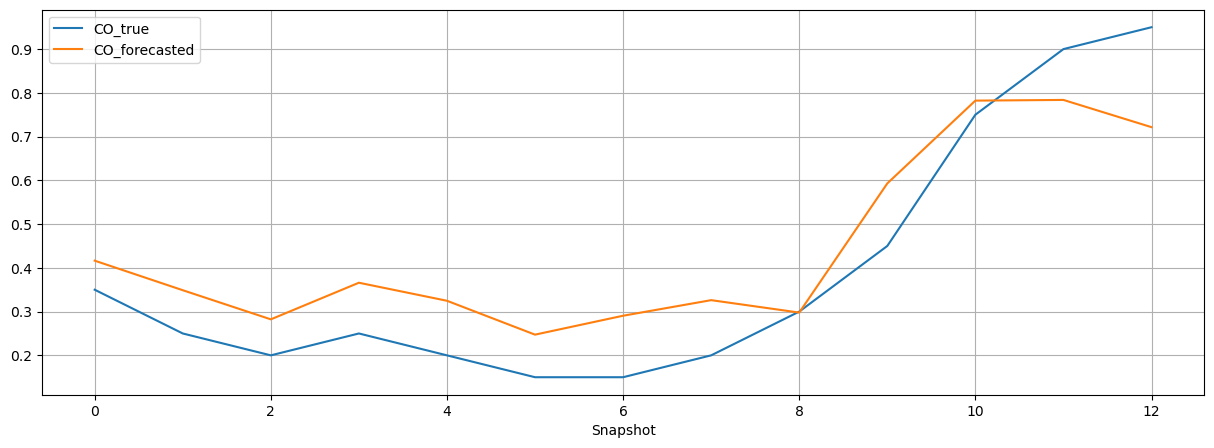

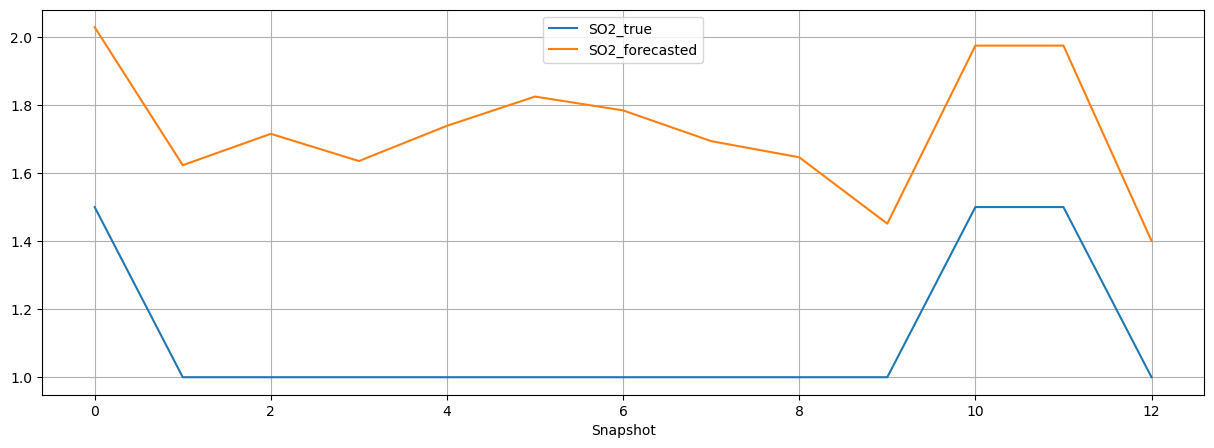

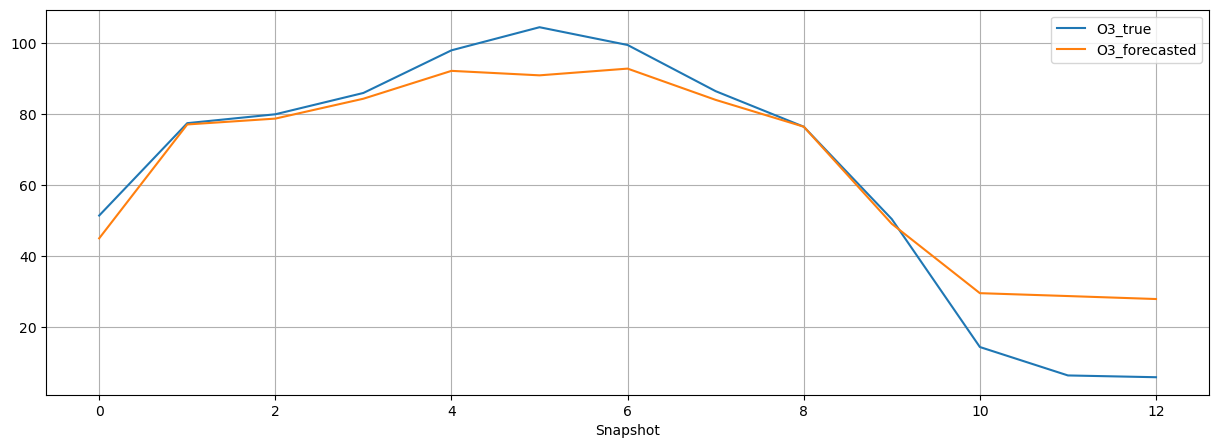

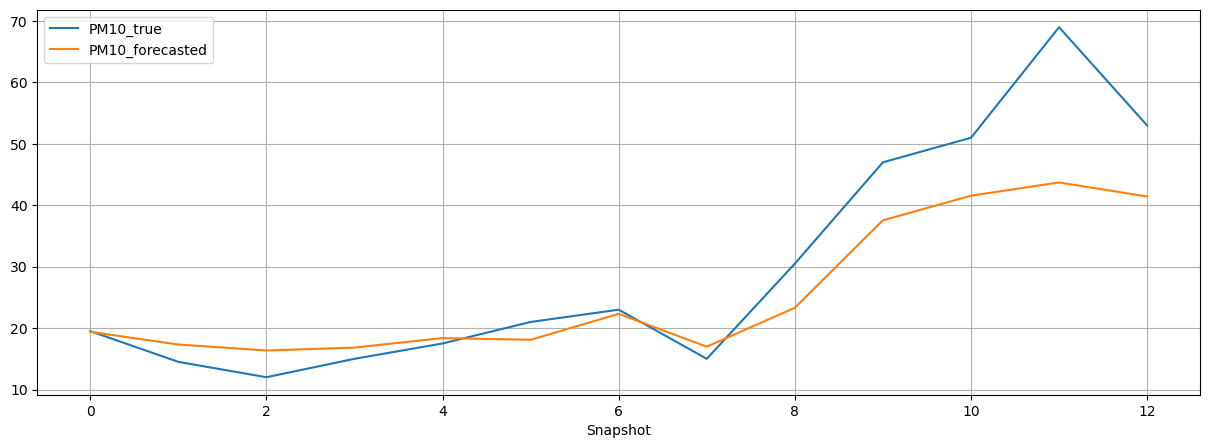

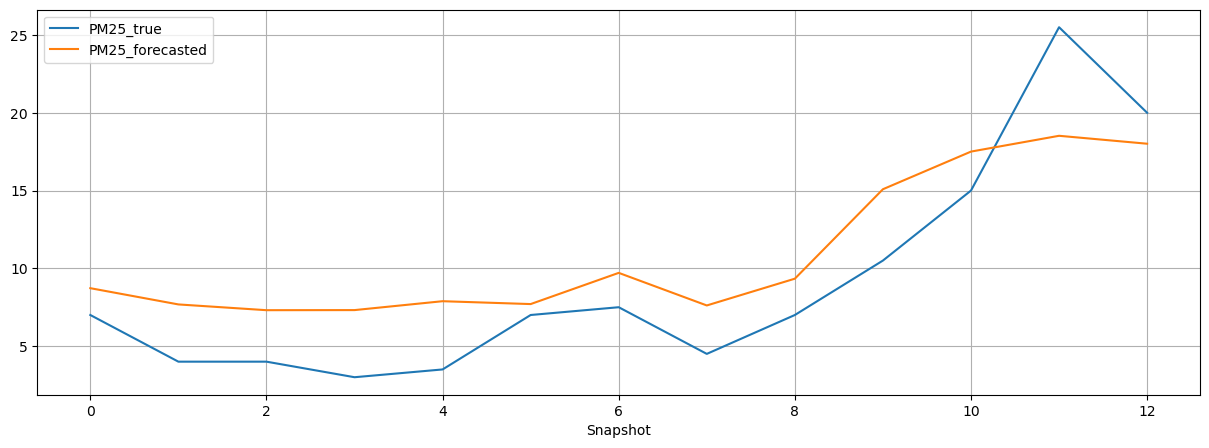

In [29]:
_trf_str= 'trf'
if not _include_trf:
    _trf_str='no_trf'

for k, lst in y_true_lst.items():
    
    df= pd.concat(lst, axis=0)
    df= df.groupby('index').mean()
    df= df.rename(columns={k:f'{k}_true'})

    lst2= y_hat_lst[k]
    y_hat_df= pd.concat(lst2, axis=0)
    y_hat_df= y_hat_df.groupby('index').mean()
    y_hat_df= y_hat_df.rename(columns={k:f'{k}_forecasted'})
    
    ax=df.plot(grid=True, figsize=(15,5));
    y_hat_df.plot(ax=ax, grid=True, xlabel='Snapshot');
    

    plt.savefig(os.path.join(os.path.join('figs', f'true_vs_forecast_{k}_{T_to_plot}_{_city}_{_trf_str}.png')), bbox_inches='tight')